In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
dir = 'dataset'

In [22]:
def load_data(dir):
    image_paths = []
    mask_paths = []
    count = 0
    print(f'Total number of folders : {len(os.listdir(dir))-2}')
    for folder in os.listdir(dir):
        patient_path = os.path.join(dir, folder)
        if not os.path.isdir(patient_path):
            continue
        for file in os.listdir(patient_path):
            count += 1
            if file.endswith('.tif') and not file.endswith('_mask.tif'):
                img_path = os.path.join(patient_path, file)
                mask_path = os.path.join(patient_path, file.replace('.tif', '_mask.tif'))
                if os.path.exists(mask_path):
                    image_paths.append(img_path)
                    mask_paths.append(mask_path)
            if (count + 1)%1000 == 0: print(count+1,'files loaded.')
    data = pd.DataFrame(data = {'images_paths' : image_paths, 'masks_paths' : mask_paths})
    print('Images and masks loaded, total number of file path loaded in dataframe :',len(image_paths) + len(mask_paths))
    return data

In [48]:
def plot_example(data, num=16):
    images_paths = data['images_paths']
    masks_paths = data['masks_paths']

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.suptitle('MRI Samples with Tumors Highlighted', fontsize=16)

    for i in range(num):
        ax = axes[i // 4, i % 4]
        image = cv2.cvtColor(cv2.imread(images_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(masks_paths[i])

        ax.imshow(image)
        ax.imshow(mask, alpha=0.4)
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

In [24]:
def get_distribution(data):
    mask_paths = data['masks_paths']
    labels_mask = pd.DataFrame(data = {'labels' : [int((np.max(cv2.imread(i))>0).astype(np.uint8)) for i in mask_paths]})
    sizes = []
    labels = ['No Tumor', 'Tumors']
    for i in range(labels_mask['labels'].unique().size):
        sizes.append(len(labels_mask[labels_mask['labels'] == i]))
    colors = sns.color_palette('pastel')

    fig, axes = plt.subplots(1, 2, figsize=(12, 8))

    wedges, texts, autotexts = axes[0].pie(
        sizes,
        labels=labels,
        colors=colors,
        startangle=45,
        autopct='%.1f%%',
        wedgeprops=dict(width=0.5),
        shadow=True
    )
    axes[0].legend(wedges, labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    axes[0].set_title('Tumor Distribution (Pie)')

    sns.countplot(
        x='labels', 
        data=labels_mask,
        palette=colors,
        ax=axes[1]
    )
    axes[1].set_xticklabels(labels)
    axes[1].set_ylabel('Number of Samples')
    axes[1].set_title('Tumor Distribution (Histogram)')

    plt.tight_layout()
    plt.show()

In [25]:
data = load_data(dir)

Total number of folders : 110
1000 files loaded.
2000 files loaded.
3000 files loaded.
4000 files loaded.
5000 files loaded.
6000 files loaded.
7000 files loaded.
Images and masks loaded, total number of file path loaded in dataframe : 7858


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   images_paths  3929 non-null   object
 1   masks_paths   3929 non-null   object
dtypes: object(2)
memory usage: 61.5+ KB


In [28]:
data.describe()

,images_paths,masks_paths
count,3929,3929
unique,3929,3929
top,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
freq,1,1


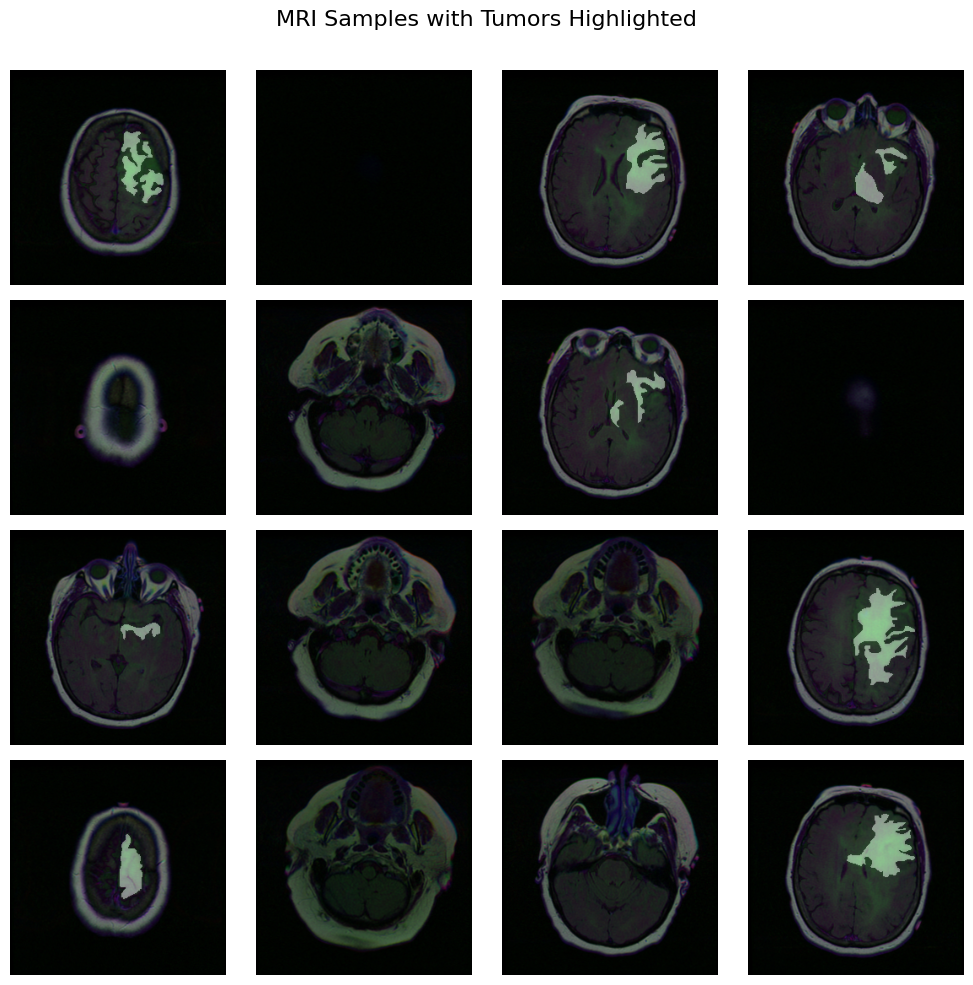

In [49]:
plot_example(data)

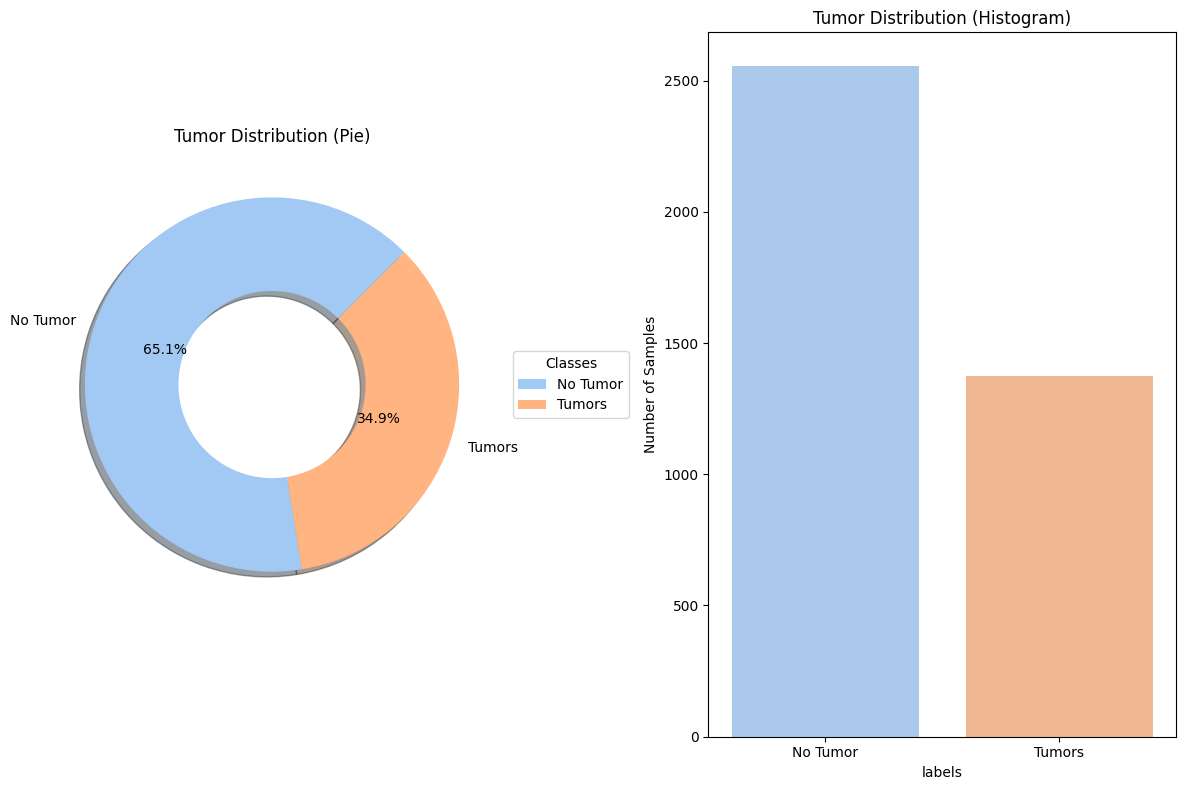

In [31]:
get_distribution(data)

In [50]:
def split(data):
    """split data -> augment -> generate"""
    train_data, dummy_data = train_test_split(data, test_size = 0.2)
    val_data, test_data = train_test_split(dummy_data, test_size = 0.5)

    return train_data, val_data, test_data


def gen(data, augment_dict = {}):
    """
    data -> split -> augment -> flow -> normalize
    """
    img_size = (256, 256)
    batch_size = 32


    img_gen = ImageDataGenerator(**augment_dict)
    msk_gen = ImageDataGenerator(**augment_dict)

    image_gen = img_gen.flow_from_dataframe(data, x_col = 'images_paths', class_mode = None, color_mode = 'rgb', target_size = img_size, batch_size = batch_size, save_to_dir = None, save_prefix = 'image', seed = 42)
    mask_gen = msk_gen.flow_from_dataframe(data, x_col = 'masks_paths', class_mode = None, color_mode = 'grayscale', target_size = img_size, batch_size = batch_size, save_to_dir = None, save_prefix = 'image', seed = 42)

    data_gen = zip(image_gen, mask_gen)
    for img, mask in data_gen:
        img /= 255.0
        mask /= 255.0
        mask[mask >= 0.5] = 1 
        mask[mask < 0.5] = 0

        yield (img, mask)



In [51]:
def conv_block(inputs = None, n_filters = 32, dropout_prob = 0, max_pooling = True):
    """ 
    inputs should be tensor of size (m, h, w, c) 
    dropout 0.3 0.4 0.5
    kernel size (paper) = 3, unpadded
    maxpool 2d f = 2, s = 2
    he_normal = rand * sqr(2/kernel_size*kernel_size*input_channels)
    """
    conv = layers.Conv2D(n_filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(inputs)
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(n_filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(conv)
    bn = layers.BatchNormalization(axis = 3)(conv)
    conv = layers.Activation('relu')(bn)
    if dropout_prob > 0:
        conv = layers.Dropout(dropout_prob)(conv)
    if max_pooling is True:
        block_layer = layers.MaxPooling2D((2,2), strides=2)(conv)
    else:
        block_layer = conv
    skip = conv

    return block_layer, skip

def conv_upsampling(block_layer, skip, n_filters):
    """
    basically conv_up = concat(2dtranspose(block_layer_i), skip_{i-1})
    conv2D(conv_up) -> conv2D(conv)
    """
    up_conv = layers.Conv2DTranspose(n_filters, (2,2), strides=2, padding='same', kernel_initializer='he_normal')(block_layer)
    up_conv = layers.Activation('relu')(up_conv)
    merge = layers.concatenate([up_conv, skip], axis=3)
    conv = layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer='he_normal')(merge)
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    return conv

def unet(input_size = (256, 256, 3)):
    inputs = layers.Input(input_size)
    conv_block1, skip1 = conv_block(inputs, 64)
    conv_block2, skip2 = conv_block(conv_block1, 128)
    conv_block3, skip3 = conv_block(conv_block2, 256)
    conv_block4, skip4 = conv_block(conv_block3, 512)
    conv_block5, _ = conv_block(conv_block4, 1024, max_pooling=False)

    conv_block6 = conv_upsampling(conv_block5, skip4, 512)
    conv_block7 = conv_upsampling(conv_block6, skip3, 256)
    conv_block8 = conv_upsampling(conv_block7, skip2, 128)
    conv_block9 = conv_upsampling(conv_block8, skip1, 64)
    
    conv_10 = layers.Conv2D(1, kernel_size=(1,1), activation='sigmoid', kernel_initializer='he_normal')(conv_block9)

    return tf.keras.Model(inputs = inputs, outputs = conv_10)

model = unet()
model.summary()




I0000 00:00:1750961726.013814      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 64, 64, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 256)    │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [54]:
def iou_coef(y_true, y_pred, epsilon=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return iou

def dice_loss(y_true, y_pred, epsilon=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + epsilon) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + epsilon)
    return 1 - dice

def dice_bce_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

def dice_coef(y_true, y_pred, epsilon=1e-6):
    y_true_f, y_pred_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32), tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + epsilon) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + epsilon)
    return dice

In [55]:
train_data, val_data, test_data = split(data)

aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = gen(train_data, augment_dict=aug_dict)
test_gen = gen(test_data)
val_gen = gen(val_data)

In [56]:
model.compile(
    optimizer = 'adam',
    loss = dice_loss,
    metrics = [
        'accuracy', 
        iou_coef,
        dice_coef
    ]
)

In [58]:
callbacks = ModelCheckpoint(
    'unet.h5',
    verbose = 1,
    save_best_only = True
)
batch_size = 32
hist = model.fit(
    train_gen,
    epochs = 100,
    steps_per_epoch = int(np.ceil(len(train_data) / batch_size)),
    verbose = 1,
    callbacks = callbacks,
    validation_data = val_gen,
    validation_steps = int(np.ceil(len(val_data)/batch_size))
)

Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/100


I0000 00:00:1750961797.837544     108 service.cc:148] XLA service 0x7df2f0002d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750961797.838684     108 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750961799.189822     108 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-26 18:16:45.929707: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-26

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.8538 - dice_coef: 0.1034 - iou_coef: 0.0559 - loss: 0.8966

E0000 00:00:1750961953.317165     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750961953.552317     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750961954.176341     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750961954.434306     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8547 - dice_coef: 0.1041 - iou_coef: 0.0563 - loss: 0.8960   Found 393 validated image filenames.
Found 393 validated image filenames.


E0000 00:00:1750961994.190773     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750961994.426489     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750961994.670224     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750961995.358984     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750961995.617398     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_loss improved from inf to 0.97678, saving model to unet.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.8556 - dice_coef: 0.1047 - iou_coef: 0.0567 - loss: 0.8953 - val_accuracy: 0.2864 - val_dice_coef: 0.0234 - val_iou_coef: 0.0119 - val_loss: 0.9768
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.9907 - dice_coef: 0.4543 - iou_coef: 0.3030 - loss: 0.5457
Epoch 2: val_loss improved from 0.97678 to 0.96795, saving model to unet.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 75s 760ms/step - accuracy: 0.9907 - dice_coef: 0.4549 - iou_coef: 0.3036 - loss: 0.5450 - val_accuracy: 0.4647 - val_dice_coef: 0.0317 - val_iou_coef: 0.0161 - val_loss: 0.9680
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.9933 - dice_coef: 0.6302 - iou_coef: 0.4713 - loss: 0.3699
Epoch 3: val_loss improved from 0.96795 to 0.40349, saving model to unet.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 74s 745ms/step - accuracy: 0.9933 - dice_coef: 0.6304 - iou_coef: 0.4715 - loss: 0.3696 - 

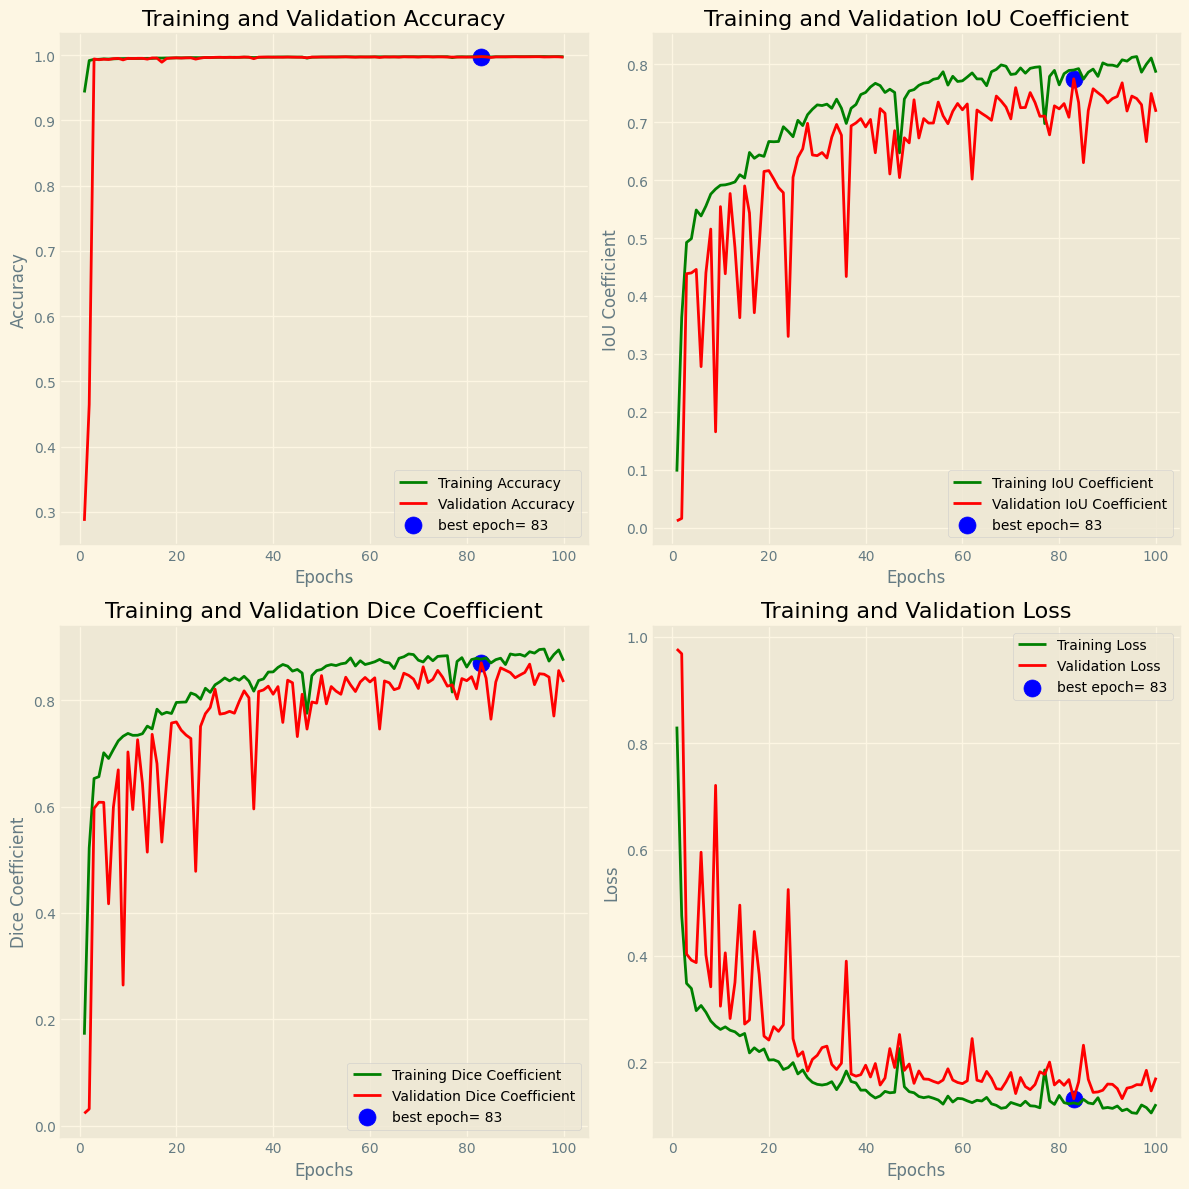

In [66]:
metrics = {
    'Accuracy':     ('accuracy', 'val_accuracy', 'Accuracy'),
    'IoU':          ('iou_coef', 'val_iou_coef', 'IoU Coefficient'),
    'Dice':         ('dice_coef', 'val_dice_coef', 'Dice Coefficient'),
    'Loss':         ('loss', 'val_loss', 'Loss')
}

epochs = list(range(1, len(hist.history['accuracy']) + 1))

plt.figure(figsize=(12, 12))
plt.style.use('Solarize_Light2')

for idx, (title, (train_key, val_key, ylabel)) in enumerate(metrics.items(), 1):
    tr_metric = hist.history[train_key]
    val_metric = hist.history[val_key]

    if 'loss' in train_key:
        best_index = np.argmin(val_metric)
        best_value = val_metric[best_index]
    else:
        best_index = np.argmax(val_metric)
        best_value = val_metric[best_index]
    
    best_label = f'best epoch= {best_index + 1}'

    plt.subplot(2, 2, idx)
    plt.plot(epochs, tr_metric, 'g', label=f'Training {ylabel}')
    plt.plot(epochs, val_metric, 'r', label=f'Validation {ylabel}')
    plt.scatter(best_index + 1, best_value, s=150, c='blue', label=best_label)
    plt.title(f'Training and Validation {ylabel}')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


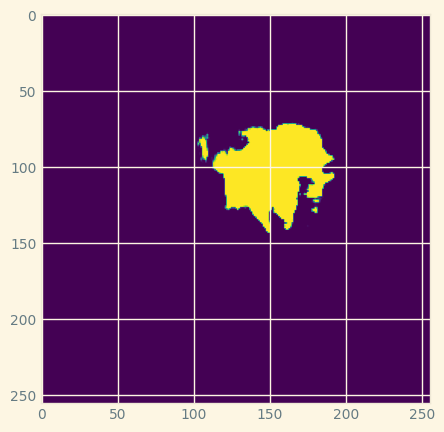

In [98]:
img = cv2.imread(test_data['images_paths'].iloc[15], cv2.COLOR_BGR2RGB)/255.0
img = img[np.newaxis, :, :, :]
pred_map = model.predict(img)
plt.imshow(np.squeeze(pred_map))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


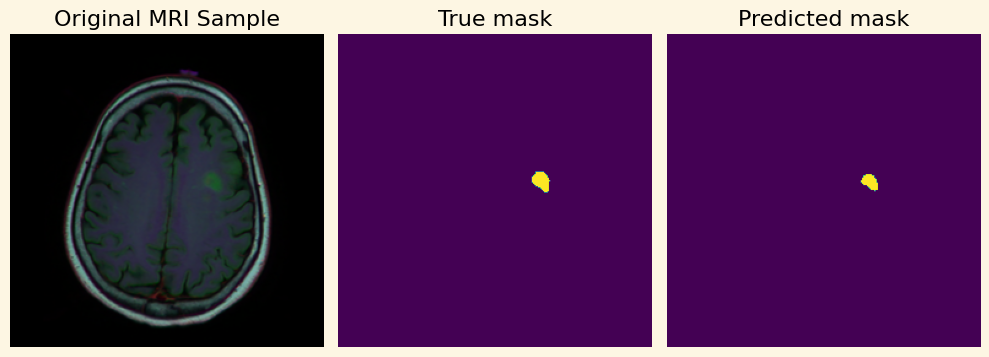

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


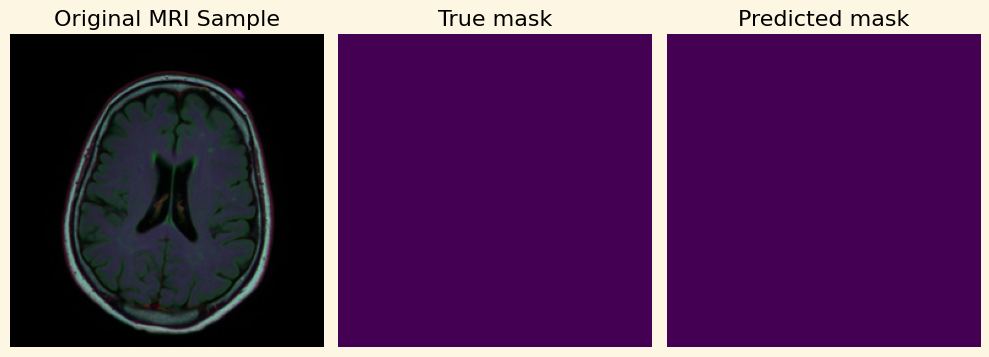

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


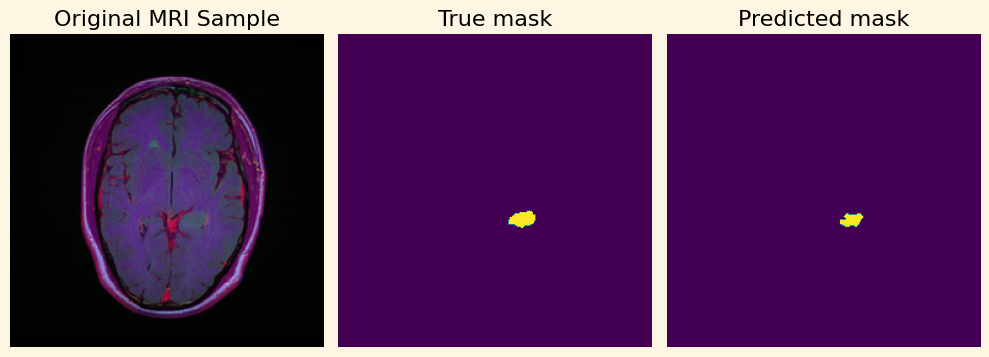

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


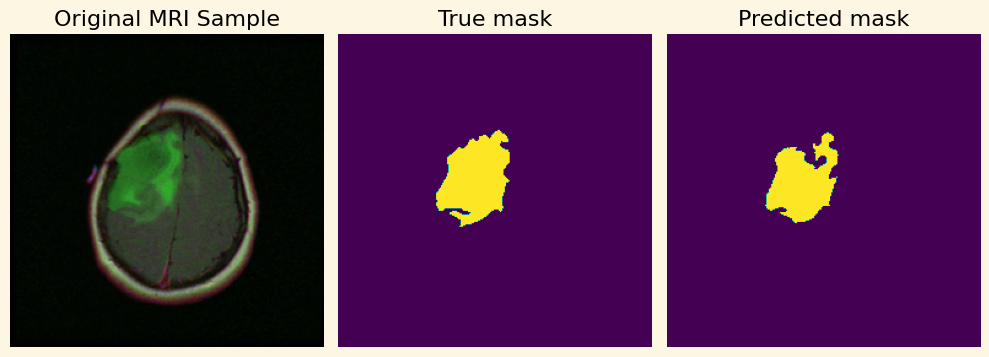

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


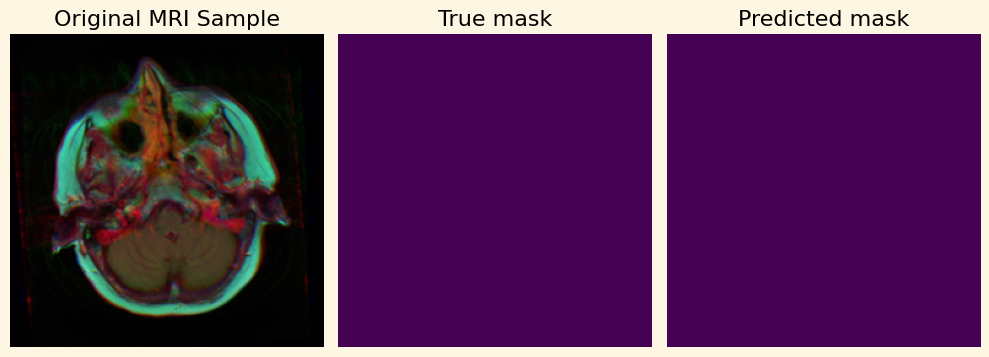

In [108]:
def predict_samples(samp = 5, threshold = 0.5):
    for _ in range(samp):
        plt.figure(figsize = (10,10))
        random_index = np.random.randint(1, len(test_data))
        img = cv2.imread(test_data['images_paths'].iloc[random_index], cv2.COLOR_BGR2RGB)/255.0
        mask = cv2.imread(test_data['masks_paths'].iloc[random_index], cv2.IMREAD_GRAYSCALE)
        img = img[np.newaxis, :, :, : ]
        pred_map = model.predict(img)
        plt.subplot(1,3,1)
        plt.imshow(np.squeeze(img))
        plt.axis('off')
        plt.title('Original MRI Sample')
        plt.subplot(1,3,2)
        plt.imshow(mask)
        plt.axis('off')
        plt.title('True mask')
        plt.subplot(1,3,3)
        plt.imshow(np.squeeze(pred_map) >= threshold)
        plt.axis('off')
        plt.title('Predicted mask')
        plt.tight_layout()
        plt.show()

predict_samples(5, 1)
    